<a href="https://colab.research.google.com/github/maniraj1234/MelanomaDetectionNN/blob/main/MelanomaDetection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Data is being committed in github repo, let's read it from there 

In [1]:
import zipfile
import os

In [2]:
!wget --no-check-certificate \
    "https://github.com/maniraj1234/MelanomaDetectionNN/archive/refs/heads/main.zip" \
    -O "/tmp/melanomaDetection.zip"

--2022-11-11 12:53:31--  https://github.com/maniraj1234/MelanomaDetectionNN/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/maniraj1234/MelanomaDetectionNN/zip/refs/heads/main [following]
--2022-11-11 12:53:32--  https://codeload.github.com/maniraj1234/MelanomaDetectionNN/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/melanomaDetection.zip’

/tmp/melanomaDetect     [           <=>      ] 785.48M  21.8MB/s    in 39s     

2022-11-11 12:54:11 (20.1 MB/s) - ‘/tmp/melanomaDetection.zip’ saved [823636334]



In [3]:
%ls /tmp

dap_multiplexer.6a178bc70e62.root.log.INFO.20221111-124212.65
dap_multiplexer.INFO@
debugger_1vc91d4p9n=
initgoogle_syslog_dir.0/
kernel_manager_proxy.6a178bc70e62.root.log.INFO.20221111-124207.19
kernel_manager_proxy.INFO@
melanomaDetection.zip
pyright-114-bVekYmgtnVsN/
pyright-114-grDA1Cx7HBAA/
python-languageserver-cancellation/


In [4]:

zip_ref = zipfile.ZipFile('/tmp/melanomaDetection.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
%ls /tmp

dap_multiplexer.6a178bc70e62.root.log.INFO.20221111-124212.65
dap_multiplexer.INFO@
debugger_1vc91d4p9n=
initgoogle_syslog_dir.0/
kernel_manager_proxy.6a178bc70e62.root.log.INFO.20221111-124207.19
kernel_manager_proxy.INFO@
MelanomaDetectionNN-main/
melanomaDetection.zip
pyright-114-bVekYmgtnVsN/
pyright-114-grDA1Cx7HBAA/
python-languageserver-cancellation/


### Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/tmp/MelanomaDetectionNN-main/Skin cancer data/Train")
data_dir_test = pathlib.Path('/tmp/MelanomaDetectionNN-main/Skin cancer data/Test')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [34]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    validation_split=0.2,
    subset="training",
    shuffle=True,
    crop_to_aspect_ratio = True,
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [35]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [37]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [16]:
num_classes = len(class_names)

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

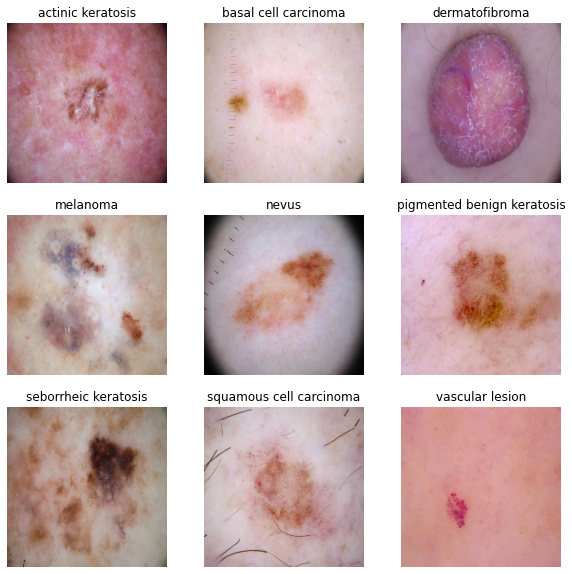

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Getting the image related to a specific class and plotting them 
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [39]:
### standardize data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0 0.99000114


In [40]:
model = Sequential([
  normalization_layer,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [41]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 128)      

### Train the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 5s 92ms/step - loss: 2.0450 - accuracy: 0.2093 - val_loss: 2.0265 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0137 - accuracy: 0.2299 - val_loss: 1.9920 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9890 - accuracy: 0.2494 - val_loss: 1.9590 - val_accuracy: 0.2595
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9550 - accuracy: 0.2852 - val_loss: 1.9342 - val_accuracy: 0.2550
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9108 - accuracy: 0.3069 - val_loss: 1.8310 - val_accuracy: 0.3535
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8804 - accuracy: 0.3131 - val_loss: 1.8580 - val_accuracy: 0.2931
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8285 - accuracy: 0.3382 - val_loss: 1.7212 - val_accuracy: 0.4027
Epoch 8/20
56/56 [======

### Visualizing training results

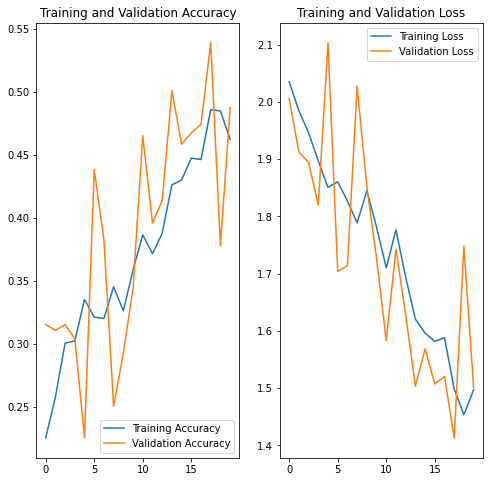

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The above model is clearly underfit, it is not able to explain the training data, hence we need to use some strategy that utilizes maximum information out of the data.

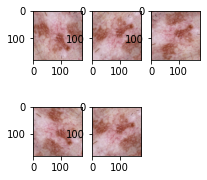

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4)
])
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
image_batch, labels_batch = next(iter(aug_ds))
plt.figure(figsize=(3,5))
for i in range(5):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(data_augmentation(image_batch[1]).numpy().astype('uint8'))


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [53]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
  normalization_layer,
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])



In [54]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Compiling the model

In [55]:
## Your code goes here
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 73ms/step - loss: 2.0727 - accuracy: 0.2054 - val_loss: 2.0270 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0248 - accuracy: 0.2093 - val_loss: 2.0321 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 2.0167 - accuracy: 0.2126 - val_loss: 2.0088 - val_accuracy: 0.2282
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 2.0052 - accuracy: 0.2305 - val_loss: 1.9956 - val_accuracy: 0.2438
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.9855 - accuracy: 0.2372 - val_loss: 1.9993 - val_accuracy: 0.1969
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9566 - accuracy: 0.2824 - val_loss: 1.9923 - val_accuracy: 0.2237
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9291 - accuracy: 0.2768 - val_loss: 1.8647 - val_accuracy: 0.3803
Epoch 8/20
56

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = ## your training code

### Visualizing the results

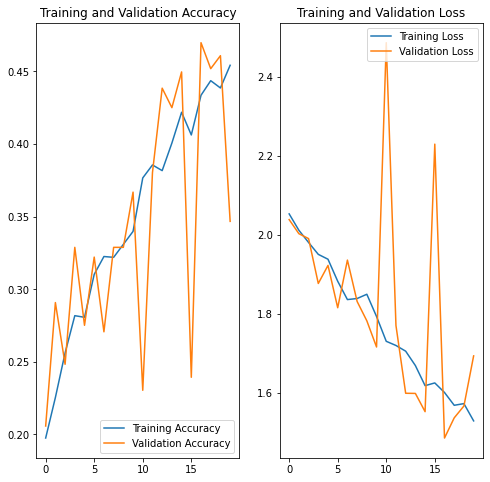

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

